In [1]:
# @title
!pip install transformers torchaudio

## 마운트

In [2]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/incheon

Mounted at /gdrive
/gdrive/MyDrive/incheon


In [3]:
# TRAIN_CSV_PATH = "./train/train.csv"
# TRAIN_AUDIO_TAR = "./train/train_audio.tar"
# VALID_CSV_PATH = "./validation/validation.csv"
# VALID_AUDIO_TAR = "./validation/valid_audio.tar"

## 코드

In [4]:
import os
import random
import ast
from typing import List, Dict
import io
import tarfile
import weakref

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, Wav2Vec2Model, AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm


# =========================================
# 1. 환경 설정 및 랜덤 시드 고정
# =========================================
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 10
TEXT_MODEL_NAME = "klue/roberta-base"
TRAIN_CSV_PATH = "./train.csv"
TRAIN_AUDIO_TAR = "./train_audio.tar"
VALID_CSV_PATH = "./validation.csv"
VALID_AUDIO_TAR = "./valid_audio.tar"
MAX_TEXT_LEN = 128
SAMPLE_RATE = 16000
MAX_AUDIO_FRAMES = 400
MIN_AUDIO_FRAMES = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")


# =========================================
# 2. 텍스트 전처리 함수
# =========================================
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

def preprocess_text(text: str, tokenizer, max_length: int = MAX_TEXT_LEN) -> Dict[str, torch.Tensor]:
    if isinstance(text, str) and len(text.strip()) > 0:
        sentences = [s.strip().strip('"') for s in text.split(',') if s.strip()]
    else:
        sentences = []
    joined_text = ' [SEP] '.join(sentences) if sentences else ''
    enc = tokenizer(
        joined_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return {k: v.squeeze(0) for k, v in enc.items()}


# =========================================
# 3. wav2vec2-XLSR 모델 초기화
# =========================================
W2V_MODEL_NAME = "facebook/wav2vec2-xls-r-300m"  # 멀티링구얼 모델 (한국어 포함)
w2v_fe = AutoFeatureExtractor.from_pretrained(W2V_MODEL_NAME)
w2v_model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME).to(device)
w2v_model.eval()

# w2v_model 동결
for p in w2v_model.parameters():
    p.requires_grad = False

# 샘플링 레이트
SAMPLE_RATE = 16000
MIN_AUDIO_FRAMES = 8
MAX_AUDIO_FRAMES = 400


# =========================================
# 4. Dataset 정의
# =========================================
class TextAudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, meta_cols: List[str], audio_tar_path: str,
                 urgency_map: Dict[str, int], sentiment_map: Dict[str, int], meta_maps: Dict[str, Dict]):
        self.df = df.reset_index(drop=True)
        self.meta_cols = meta_cols
        self.audio_tar_path = audio_tar_path
        self.urgency_map = urgency_map
        self.sentiment_map = sentiment_map

        # 메타데이터 인덱스 매핑
        self.meta_maps = meta_maps
        self.meta_vocab_sizes = {col: len(self.meta_maps.get(col, {})) + 1 for col in meta_cols}

        # 오디오 로딩 (tar 내부)
        self.tar = None
        self.member_map = {}
        self.audio_cache = {}  # {basename: bytes}

        if audio_tar_path and os.path.exists(audio_tar_path):
            mode = 'r:gz' if audio_tar_path.endswith(('.tar.gz', '.tgz')) else 'r'
            self.tar = tarfile.open(audio_tar_path, mode)
            # 필요한 순간에 extractfile 하려고 인덱스만 만든다.
            for m in self.tar.getmembers():
                if m.isfile():
                    self.member_map[os.path.basename(m.name)] = m
        # tar는 객체 수명 끝나면 닫히도록
        self._finalizer = weakref.finalize(self, self._cleanup)


    def _cleanup(self):
        try:
            if self.tar is not None:
                self.tar.close()
        except Exception:
            pass

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # -----------------------------
        # 1) 텍스트 처리
        # -----------------------------
        text_enc = preprocess_text(row.get('text', ''), tokenizer, MAX_TEXT_LEN)

        # -----------------------------
        # 2) wav2vec2-XLSR 오디오 처리
        # -----------------------------
        audio_paths = []
        if 'audio_split_list' in row and pd.notna(row['audio_split_list']):
            try:
                audio_paths = ast.literal_eval(row['audio_split_list'])
                if not isinstance(audio_paths, (list, tuple)):
                    audio_paths = []
            except Exception:
                audio_paths = []

        features = []
        for audio_file in audio_paths:
            audio_bytes = self.audio_cache.get(audio_file)
            if audio_bytes is None and self.tar is not None:
                m = self.member_map.get(audio_file)
                if m is not None:
                    f = self.tar.extractfile(m)
                    if f:
                        audio_bytes = f.read()
                        self.audio_cache[audio_file] = audio_bytes  # 1번 읽은 건 캐시
            if audio_bytes is None:
                features.append(None)
                continue

            try:
                waveform, sr = torchaudio.load(io.BytesIO(audio_bytes))  # (ch, T)
            except Exception:
                features.append(None)
                continue

            # mono + 16k
            if waveform.dim() == 2 and waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            with torch.no_grad():
                fe_out = w2v_fe(
                    waveform.squeeze(0).numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
                )
                input_values = fe_out.input_values.to(device)  # (1, T')
                out = w2v_model(input_values)                  # (1, t, d)
                hs = out.last_hidden_state.squeeze(0)          # (t, d)
                hs = hs.transpose(0, 1).contiguous()           # (d, t)

                # 프레임 패딩/자르기 (기존 하이퍼 재사용)
                frames = hs.size(1)
                if frames < MAX_AUDIO_FRAMES:
                    hs = torch.nn.functional.pad(hs, (0, MAX_AUDIO_FRAMES - frames))  # ← 무조건 MAX에 맞추기
                else:
                    hs = hs[:, :MAX_AUDIO_FRAMES]
                features.append(hs)

        # 여러 조각 평균, 없으면 0-텐서
        D = w2v_model.config.hidden_size  # 예: 1024(300m)

        # None이 아닌 유효한 피처만 필터링해서 그 피처들로만 평균값
        valid_features = [f for f in features if f is not None]

        if not valid_features:      # 유효한 피처가 하나도 없으면
            audio_feat = torch.zeros(D, MAX_AUDIO_FRAMES, device=device)
        else:
            # 2. 유효한 피처들만 스택하고 평균
            # (루프 안에서 이미 MAX_AUDIO_FRAMES로 패딩/잘라내기 되었음)
            audio_feat = torch.stack(valid_features, dim=0).mean(dim=0)

        # -----------------------------
        # 3) 메타데이터 처리
        # -----------------------------
        meta_idx = []
        for col in self.meta_cols:
            val = row.get(col, None)
            idx_val = 0 if pd.isna(val) or val is None else self.meta_maps.get(col, {}).get(val, 0)
            vocab_size = self.meta_vocab_sizes.get(col, 1)
            idx_val = max(0, min(idx_val, vocab_size-1))
            meta_idx.append(idx_val)
        meta_idx = torch.tensor(meta_idx, dtype=torch.long) if meta_idx else torch.tensor([0], dtype=torch.long)

        # -----------------------------
        # 4) Labels 처리
        # -----------------------------
        urg_val = row.get('urgencyLevel', None)
        urgency = self.urgency_map.get(urg_val, self.urgency_map.get(str(urg_val), 0))
        try:
            urgency = int(urgency)
        except Exception:
            urgency = 0
        urgency = torch.tensor(urgency, dtype=torch.long)

        sent_val = row.get('sentiment', None)
        sentiment_idx = self.sentiment_map.get(sent_val, self.sentiment_map.get(str(sent_val), 0))

        num_classes = max(1, len(self.sentiment_map))
        sentiment_idx = max(0, min(sentiment_idx, num_classes-1))
        sentiment = torch.tensor(sentiment_idx, dtype=torch.long)

        return {
            'input_ids': text_enc['input_ids'].to(device),
            'attention_mask': text_enc['attention_mask'].to(device),
            'audio_feat': audio_feat.to(device),
            'meta_idx': meta_idx.to(device),
            'urgency': urgency.to(device),
            'sentiment': sentiment.to(device)
        }


# =========================================
# 3-1. collate_fn: dynamic padding
# =========================================
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    meta_idx = torch.stack([item['meta_idx'] for item in batch])
    urgency = torch.stack([item['urgency'] for item in batch])
    sentiment = torch.stack([item['sentiment'] for item in batch])

    audio_feats = [item['audio_feat'] for item in batch]
    max_frames = max([feat.size(1) for feat in audio_feats])
    padded_audio = [torch.nn.functional.pad(feat, (0, max_frames - feat.size(1))) for feat in audio_feats]
    audio_feat = torch.stack(padded_audio)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'audio_feat': audio_feat,
        'meta_idx': meta_idx,
        'urgency': urgency,
        'sentiment': sentiment
    }


# =========================================
# 4. 모델 정의 (HuBERT용)
# =========================================
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_name, meta_maps: Dict[str, Dict],
                 audio_emb_dim=256, joint_dim=256,
                 num_classes_urgency=3,
                 num_classes_sentiment=4,
                 audio_input_dim=None):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)

        # 텍스트 모델 동결 (학습시키지 않음)
        #  for p in self.text_encoder.parameters():
        #   p.requires_grad = False

        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, joint_dim)

        if audio_input_dim is None:
            audio_input_dim = w2v_model.config.hidden_size
            # HuBERT의 hidden dim

        self.audio_proj_shared   = nn.Linear(audio_input_dim, audio_emb_dim)
        self.audio_proj_urgency  = nn.Linear(audio_emb_dim, joint_dim)
        self.audio_proj_sentiment= nn.Linear(audio_emb_dim, joint_dim)

        self.meta_embs = nn.ModuleDict()
        for k, mapping in meta_maps.items():
            num_embeddings = len(mapping) + 1
            emb_dim = min(8, num_embeddings)
            self.meta_embs[k] = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=emb_dim, padding_idx=0)
        self.meta_out_dim = sum([emb.embedding_dim for emb in self.meta_embs.values()]) if self.meta_embs else 0

        # concat 방식으로 변경: joint_dim * 2 (텍스트 + 오디오)
        self.urgency_head = nn.Linear(joint_dim * 2 + self.meta_out_dim, num_classes_urgency)
        self.sentiment_head = nn.Sequential(
            nn.Linear(joint_dim * 2 + self.meta_out_dim, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, num_classes_sentiment)
        )

    def forward(self, input_ids, attention_mask, audio_feat, meta_idx):
        B = input_ids.size(0)
        txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        txt_emb = self.text_proj(txt_out.last_hidden_state[:, 0, :])

        # audio_feat: (B, D, T)
        audio_mean = audio_feat.mean(dim=2)  # (B, D)
        audio_emb = self.audio_proj_shared(audio_mean)
        audio_emb_urgency  = self.audio_proj_urgency(audio_emb)
        audio_emb_sentiment= self.audio_proj_sentiment(audio_emb)

        if not self.meta_embs:
            meta_emb = torch.zeros(B, 0, device=input_ids.device)
        else:
            if meta_idx.dim() == 1:
                meta_idx = meta_idx.unsqueeze(0).expand(B, -1)
            meta_embeddings = [self.meta_embs[k](meta_idx[:, i].clamp(0, self.meta_embs[k].num_embeddings-1))
                               for i, k in enumerate(self.meta_embs.keys())]
            meta_emb = torch.cat(meta_embeddings, dim=1)


        # sum 대신 concat으로 변경
        joint_urgency   = torch.cat([txt_emb, audio_emb_urgency], dim=1)
        joint_sentiment = torch.cat([txt_emb, audio_emb_sentiment], dim=1)

        urg_out = self.urgency_head(torch.cat([joint_urgency, meta_emb], dim=1))
        sent_out = self.sentiment_head(torch.cat([joint_sentiment, meta_emb], dim=1))
        return urg_out, sent_out


# =========================================
# 5. 학습 함수
# =========================================
def train_model(df_train, df_valid, meta_cols, train_tar, valid_tar,
                urgency_map, sentiment_map, meta_maps,
                num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):

    # meta_maps = {col: {v: (i + 1) for i, v in enumerate(df_train[col].dropna().unique())} for col in meta_cols}
    train_dataset = TextAudioDataset(df_train, meta_cols, train_tar, urgency_map, sentiment_map, meta_maps)
    valid_dataset = TextAudioDataset(df_valid, meta_cols, valid_tar, urgency_map, sentiment_map, meta_maps)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model = MultimodalClassifier(
        TEXT_MODEL_NAME, meta_maps,
        num_classes_urgency=len(urgency_map),
        num_classes_sentiment=len(sentiment_map),
        audio_input_dim=w2v_model.config.hidden_size
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion_urg = nn.CrossEntropyLoss()
    criterion_sent = nn.CrossEntropyLoss()

    train_losses, train_urg_losses, train_sent_losses = [], [], []
    valid_losses, valid_urg_losses, valid_sent_losses = [], [], []
    urg_acc_list, urg_f1_list, sent_acc_list, sent_f1_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_urg, total_train_sent = 0.0, 0.0, 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                        batch['audio_feat'], batch['meta_idx'])
            urg_loss = criterion_urg(pred_urg, batch['urgency'])
            sent_loss = criterion_sent(pred_sent, batch['sentiment'])
            loss = urg_loss + sent_loss

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_urg += urg_loss.item()
            total_train_sent += sent_loss.item()

        train_losses.append(total_train_loss / len(train_loader))
        train_urg_losses.append(total_train_urg / len(train_loader))
        train_sent_losses.append(total_train_sent / len(train_loader))

        model.eval()
        total_valid_loss, total_valid_urg, total_valid_sent = 0, 0, 0
        all_urg_pred, all_urg_true = [], []
        all_sent_pred, all_sent_true = [], []

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]"):
                pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                            batch['audio_feat'], batch['meta_idx'])
                urg_loss = criterion_urg(pred_urg, batch['urgency'])
                sent_loss = criterion_sent(pred_sent, batch['sentiment'])
                loss = urg_loss + sent_loss

                total_valid_loss += loss.item()
                total_valid_urg += urg_loss.item()
                total_valid_sent += sent_loss.item()

                all_urg_pred.extend(pred_urg.argmax(dim=1).cpu().numpy())
                all_urg_true.extend(batch['urgency'].cpu().numpy())
                all_sent_pred.extend(pred_sent.argmax(dim=1).cpu().numpy())
                all_sent_true.extend(batch['sentiment'].cpu().numpy())

        valid_losses.append(total_valid_loss / len(valid_loader))
        valid_urg_losses.append(total_valid_urg / len(valid_loader))
        valid_sent_losses.append(total_valid_sent / len(valid_loader))

        urg_acc = accuracy_score(all_urg_true, all_urg_pred)
        urg_f1 = f1_score(all_urg_true, all_urg_pred, average='weighted')
        sent_acc = accuracy_score(all_sent_true, all_sent_pred) # (변수명만 명확하게 변경)
        sent_f1 = f1_score(all_sent_true, all_sent_pred, average='weighted') # (변수명만 명확하게 변경)

        urg_acc_list.append(urg_acc)
        urg_f1_list.append(urg_f1)
        sent_acc_list.append(sent_acc)
        sent_f1_list.append(sent_f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Valid Loss: {valid_losses[-1]:.4f}")
        print(f"Train Urg Loss: {train_urg_losses[-1]:.4f} | Train Sent Loss: {train_sent_losses[-1]:.4f}")
        print(f"Valid Urg Loss: {valid_urg_losses[-1]:.4f} | Valid Sent Loss: {valid_sent_losses[-1]:.4f}")
        print(f"Urgency -> Accuracy: {urg_acc:.4f}, Weighted F1: {urg_f1:.4f}")
        print(f"Sentiment -> Accuracy: {sent_acc:.4f}, Weighted F1: {sent_f1:.4f}\n")

    scores = {
        'train_loss': train_losses, 'train_urg_loss': train_urg_losses, 'train_sent_loss': train_sent_losses,
        'valid_loss': valid_losses, 'valid_urg_loss': valid_urg_losses, 'valid_sent_loss': valid_sent_losses,
        'urg_accuracy': urg_acc_list, 'urg_f1': urg_f1_list,
        'sent_accuracy': sent_acc_list, 'sent_f1': sent_f1_list
    }
    return model, scores


# =========================================
# 6. 학습 결과 시각화
# =========================================
def plot_scores(scores):
    epochs = range(1, len(scores['train_loss'])+1)
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs, scores['train_urg_loss'], label='Train Urg Loss')
    plt.plot(epochs, scores['train_sent_loss'], label='Train Sent Loss')
    plt.plot(epochs, scores['valid_urg_loss'], '--', label='Valid Urg Loss')
    plt.plot(epochs, scores['valid_sent_loss'], '--', label='Valid Sent Loss')
    plt.title('Task Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, scores['urg_accuracy'], label='Urg Accuracy')
    plt.plot(epochs, scores['urg_f1'], label='Urg F1')
    plt.plot(epochs, scores['sent_accuracy'], label='Sent Accuracy')
    plt.plot(epochs, scores['sent_f1'], label='Sent F1')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.show()

device : cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

(500, 15)


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecod


Epoch 1/10
Train Loss: 2.1113 | Valid Loss: 2.1017
Train Urg Loss: 1.1234 | Train Sent Loss: 0.9879
Valid Urg Loss: 1.1658 | Valid Sent Loss: 0.9359
Urgency -> Accuracy: 0.2700, Weighted F1: 0.1148
Sentiment -> Accuracy: 0.5700, Weighted F1: 0.4139



Epoch 2 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 2/10
Train Loss: 1.9638 | Valid Loss: 1.9315
Train Urg Loss: 1.1094 | Train Sent Loss: 0.8545
Valid Urg Loss: 1.0998 | Valid Sent Loss: 0.8317
Urgency -> Accuracy: 0.2300, Weighted F1: 0.1501
Sentiment -> Accuracy: 0.5700, Weighted F1: 0.4139



Epoch 3 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 3/10
Train Loss: 1.9491 | Valid Loss: 1.9451
Train Urg Loss: 1.1133 | Train Sent Loss: 0.8358
Valid Urg Loss: 1.1109 | Valid Sent Loss: 0.8342
Urgency -> Accuracy: 0.2900, Weighted F1: 0.2138
Sentiment -> Accuracy: 0.6400, Weighted F1: 0.5769



Epoch 4 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 4/10
Train Loss: 1.9469 | Valid Loss: 1.9252
Train Urg Loss: 1.1082 | Train Sent Loss: 0.8387
Valid Urg Loss: 1.0956 | Valid Sent Loss: 0.8296
Urgency -> Accuracy: 0.3500, Weighted F1: 0.1856
Sentiment -> Accuracy: 0.6000, Weighted F1: 0.5034



Epoch 5 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 5/10
Train Loss: 1.9409 | Valid Loss: 1.9309
Train Urg Loss: 1.1114 | Train Sent Loss: 0.8295
Valid Urg Loss: 1.0999 | Valid Sent Loss: 0.8310
Urgency -> Accuracy: 0.3500, Weighted F1: 0.1815
Sentiment -> Accuracy: 0.6600, Weighted F1: 0.6055



Epoch 6 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 6/10
Train Loss: 1.9214 | Valid Loss: 1.9299
Train Urg Loss: 1.0946 | Train Sent Loss: 0.8267
Valid Urg Loss: 1.0963 | Valid Sent Loss: 0.8336
Urgency -> Accuracy: 0.3500, Weighted F1: 0.1815
Sentiment -> Accuracy: 0.6800, Weighted F1: 0.6375



Epoch 7 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 7/10
Train Loss: 1.9154 | Valid Loss: 1.9151
Train Urg Loss: 1.0945 | Train Sent Loss: 0.8209
Valid Urg Loss: 1.0939 | Valid Sent Loss: 0.8212
Urgency -> Accuracy: 0.3200, Weighted F1: 0.1778
Sentiment -> Accuracy: 0.6000, Weighted F1: 0.5034



Epoch 8 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 8/10
Train Loss: 1.9228 | Valid Loss: 1.9063
Train Urg Loss: 1.0946 | Train Sent Loss: 0.8282
Valid Urg Loss: 1.0880 | Valid Sent Loss: 0.8183
Urgency -> Accuracy: 0.3700, Weighted F1: 0.3065
Sentiment -> Accuracy: 0.6400, Weighted F1: 0.5769



Epoch 9 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 9/10
Train Loss: 1.9303 | Valid Loss: 1.9123
Train Urg Loss: 1.1005 | Train Sent Loss: 0.8297
Valid Urg Loss: 1.0854 | Valid Sent Loss: 0.8269
Urgency -> Accuracy: 0.3400, Weighted F1: 0.1859
Sentiment -> Accuracy: 0.6800, Weighted F1: 0.6375



Epoch 10 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto


Epoch 10/10
Train Loss: 1.8947 | Valid Loss: 1.9069
Train Urg Loss: 1.0827 | Train Sent Loss: 0.8120
Valid Urg Loss: 1.0861 | Valid Sent Loss: 0.8208
Urgency -> Accuracy: 0.4600, Weighted F1: 0.3530
Sentiment -> Accuracy: 0.6800, Weighted F1: 0.6375



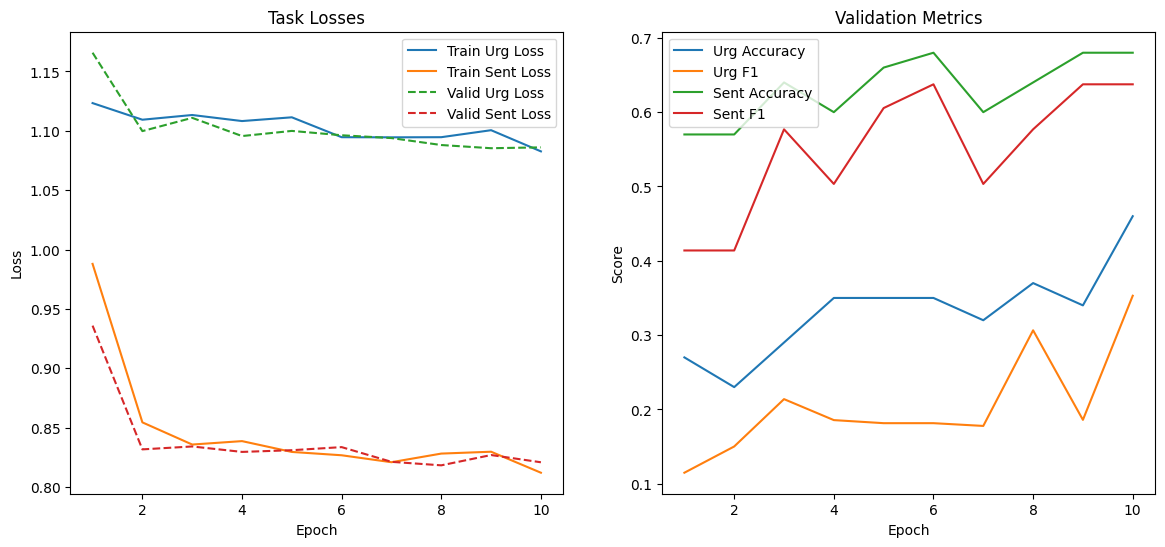

In [5]:
# =========================================
# 7. 학습 실행
# =========================================
df = pd.read_csv(TRAIN_CSV_PATH)

# 데이터 'disasterLarge' 비율 맞춰 추출
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
LABEL_COL = "disasterLarge"  # 비율 기준 컬럼명
TARGET_N = 500               # 다운샘플 목표 개수
RS = SEED

if LABEL_COL in df.columns and len(df) > TARGET_N:
    counts = df[LABEL_COL].value_counts(dropna=False)
    probs = counts / counts.sum()
    raw = probs * TARGET_N

    base = np.floor(raw).astype(int)                # 기본 할당
    leftover = int(TARGET_N - base.sum())           # 남은 몫
    remainders = (raw - base).sort_values(ascending=False)

    alloc = base.copy()
    for lbl in remainders.index[:leftover]:
        alloc[lbl] += 1

    # 각 그룹에서 할당 수만큼 샘플 (그룹 실제 크기보다 큰 경우 cap)
    parts = []
    for lbl, n_take in alloc.items():
        grp = df[df[LABEL_COL] == lbl]
        n_final = min(len(grp), int(n_take))
        if n_final > 0:
            parts.append(grp.sample(n=n_final, random_state=RS))
    df = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RS).reset_index(drop=True)
print(df.shape)
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

meta_cols = ['gender','disasterLarge','disasterMedium']


# 분리 전에 전체 데이터로 meta_maps 생성
meta_maps = {}
for col in meta_cols:
    uniques = list(df[col].dropna().unique())
    meta_maps[col] = {v: (i + 1) for i, v in enumerate(uniques)} # 0은 padding/unknown 용

urgency_map = {'상': 2, '중': 1, '하': 0}
sentiment_map = {'불안/걱정':0, '당황/난처':1, '중립':2, '기타부정':3}

valid_size = int(len(df) * 0.2)
df_train = df.iloc[:-valid_size].reset_index(drop=True)
df_valid = df.iloc[-valid_size:].reset_index(drop=True)

# 모델 학습 및 평가
model, scores = train_model(df_train, df_valid, meta_cols,
                            TRAIN_AUDIO_TAR, VALID_AUDIO_TAR,
                            urgency_map, sentiment_map,
                            meta_maps=meta_maps,
                            num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

# 학습 결과 시각화
plot_scores(scores)

In [6]:
# =========================================
# 10. 테스트/추론
# =========================================
print("========================= 테스트 =========================")

# 테스트 데이터 로드
df_test = pd.read_csv(VALID_CSV_PATH)

# 테스트용 Dataset 생성
test_dataset = TextAudioDataset(df_test, meta_cols, VALID_AUDIO_TAR, urgency_map, sentiment_map, meta_maps)

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 모델 평가 모드
model.eval()

# 결과 저장 리스트 초기화
preds_urgency, preds_sentiment = [], []
labels_urgency, labels_sentiment = [], []

# 테스트 루프
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        audio_feat = batch['audio_feat']
        meta_idx = batch['meta_idx']
        label_urgency = batch['urgency']
        label_sentiment = batch['sentiment']

        # 예측
        pred_urg, pred_sent = model(input_ids, attention_mask, audio_feat, meta_idx)

        # 결과 저장
        preds_urgency.extend(torch.argmax(pred_urg, dim=1).cpu().tolist())
        preds_sentiment.extend(torch.argmax(pred_sent, dim=1).cpu().tolist())
        labels_urgency.extend(label_urgency.cpu().tolist())
        labels_sentiment.extend(label_sentiment.cpu().tolist())

# Urgency 평가 (분류)
acc_urg = accuracy_score(labels_urgency, preds_urgency)
f1_urg = f1_score(labels_urgency, preds_urgency, average='weighted')

# Sentiment 평가 (분류)
acc_sent = accuracy_score(labels_sentiment, preds_sentiment)
f1_sent = f1_score(labels_sentiment, preds_sentiment, average='weighted')

# 출력
print(f"Test Accuracy (urgency): {acc_urg:.4f}")
print(f"Test Weighted F1 (urgency): {f1_urg:.4f}")
print(f"Test Accuracy (sentiment): {acc_sent:.4f}")
print(f"Test Weighted F1 (sentiment): {f1_sent:.4f}")

========================= 테스트 =========================


Test:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/i

Test Accuracy (urgency): 0.4230
Test Weighted F1 (urgency): 0.2701
Test Accuracy (sentiment): 0.6502
Test Weighted F1 (sentiment): 0.5995
